# Como a Malha Metroviária de São Paulo Atende às Demandas em Comparação com as Melhores Malhas atuais?

### À partir da comparação da malha metroviária de São Paulo com cidades similares em tamanho, mas que por sua vez atendem com maior eficiência sua população, podemos encontrar soluções para futuras expansões do metrô atualmente


### Hipotese

Bairros com alta densidade populacional ou bairros que atendem grandes quantidades de pessoas durante a jornada de trabalho diária são os bairros que mais necessitam suporte metroviário na cidade

In [1]:
import pandas as pd
import os
from pointpats.centrography import hull, mbr, mean_center, weighted_mean_center, manhattan_median, std_distance,euclidean_median,ellipse
from pointpats import PointPattern
import pointpats.quadrat_statistics as qs
from pointpats.distance_statistics import g, f, k
from pointpats import PoissonPointProcess
import numpy as np
from sklearn.neighbors import KernelDensity
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# São Paulo

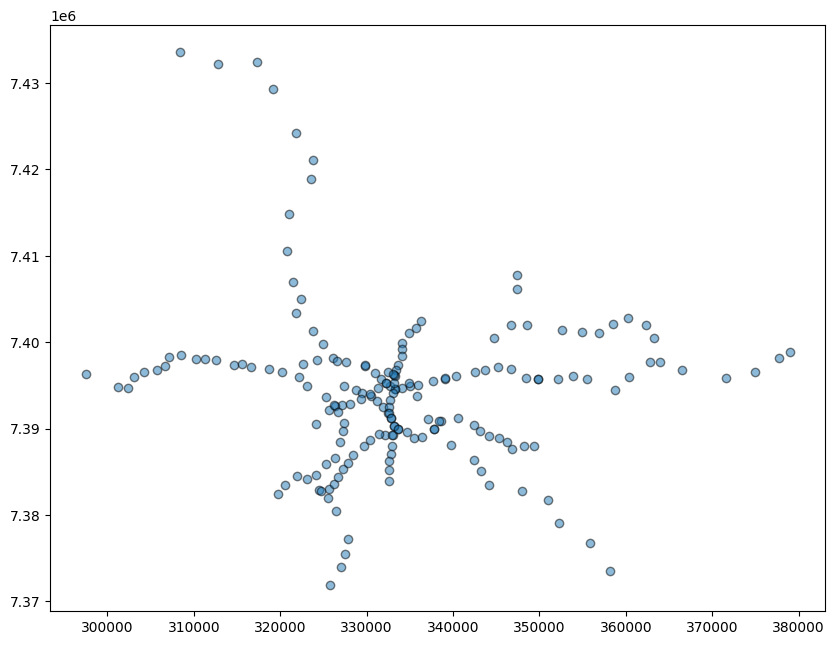

In [16]:
# Set the path to the directory containing your shapefiles
directory = "data/metro_trem_sp/"  # Replace with the path to your files

# List of shapefiles to load
shapefiles = [
    "SIRGAS_SHP_estacaometro_point.shp",
    "SIRGAS_SHP_estacaotrem.shp",
]

# Initialize an empty list to hold GeoDataFrames
gdfs = []

# Loop through the shapefiles, read them, and append to the list
for shp in shapefiles:
    filepath = os.path.join(directory, shp)
    try:
        # Read the shapefile into a GeoDataFrame
        gdf = gpd.read_file(filepath)
        gdfs.append(gdf)
    except Exception as e:
        print(f"Could not read {shp}: {e}")

# Concatenate all GeoDataFrames into one if available
if gdfs:
    combined_gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))

    # Plot the combined GeoDataFrame
    combined_gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
    plt.show()
else:
    print("No valid shapefiles found.")


In [17]:
combined_gdf.crs

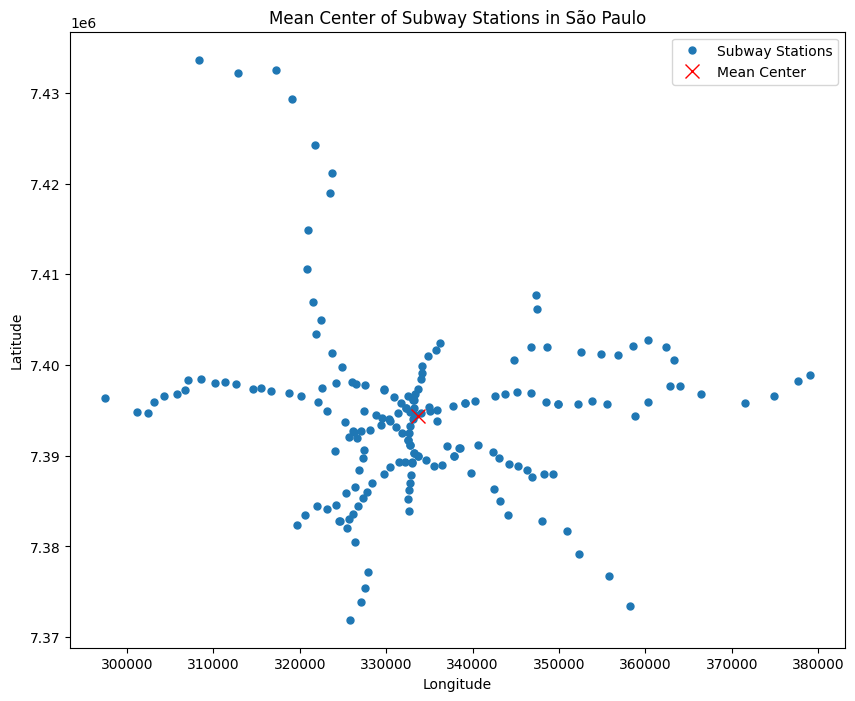

In [2]:
directory = "data/metro_trem_sp/"  # Replace with the path to your files

# List of shapefiles to load
shapefiles = [
    "SIRGAS_SHP_estacaometro_point.shp",
    "SIRGAS_SHP_estacaotrem.shp"
]

# Initialize an empty list to hold GeoDataFrames
gdfs = []

# Loop through the shapefiles, read them, and append to the list
for shp in shapefiles:
    filepath = os.path.join(directory, shp)
    try:
        # Read the shapefile into a GeoDataFrame
        gdf = gpd.read_file(filepath)
        gdfs.append(gdf)
    except Exception as e:
        print(f"Could not read {shp}: {e}")

# Concatenate all GeoDataFrames containing point data into one if available
if gdfs:
    combined_gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))

    # Extract x and y coordinates
    combined_gdf['x'] = combined_gdf.geometry.x
    combined_gdf['y'] = combined_gdf.geometry.y

    # Create a PointPattern for mean center calculation
    coordinates = combined_gdf[['x', 'y']].values
    point_pattern = PointPattern(coordinates)

    # Calculate mean center
    mean_center_coords = mean_center(point_pattern.points)

    # Plot subway station points and the mean center
    plt.figure(figsize=(10, 8))
    plt.plot(point_pattern.points['x'], point_pattern.points['y'], 'o', markersize=5, label='Subway Stations')
    plt.plot(mean_center_coords[0], mean_center_coords[1], 'x', markersize=10, color='red', label='Mean Center')
    plt.legend()
    plt.title('Mean Center of Subway Stations in São Paulo')
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()


In [4]:
%matplotlib inline


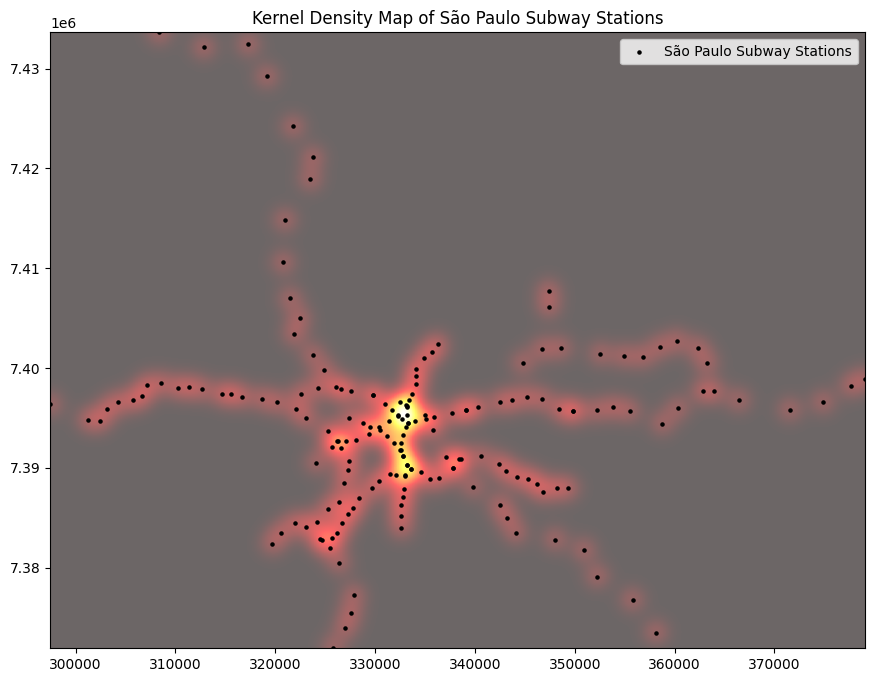

In [8]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

# Path to directory and shapefiles for São Paulo subway stations
directory = "data/metro_trem_sp/"  # Replace with your actual path
shapefiles = ["SIRGAS_SHP_estacaometro_point.shp", "SIRGAS_SHP_estacaotrem.shp"]

# Load the GeoDataFrames and concatenate them
gdfs = [gpd.read_file(directory + shp) for shp in shapefiles]
combined_gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))

# Extract coordinates for KDE
combined_gdf['x'] = combined_gdf.geometry.x
combined_gdf['y'] = combined_gdf.geometry.y
station_coords = combined_gdf[['x', 'y']].values

# Perform KDE
kde = KernelDensity(bandwidth=1000, kernel='gaussian')  # Adjust bandwidth as needed
kde.fit(station_coords)

# Define the grid
xmin, ymin, xmax, ymax = combined_gdf.total_bounds
xgrid = np.linspace(xmin, xmax, 500)
ygrid = np.linspace(ymin, ymax, 500)
xv, yv = np.meshgrid(xgrid, ygrid)
grid_coords = np.vstack([xv.ravel(), yv.ravel()]).T

# Calculate density
density = np.exp(kde.score_samples(grid_coords))
density = density.reshape(500, 500)

# Plot
fig, ax = plt.subplots(figsize=(12, 8), dpi=100)  # Increase figure size and DPI

# Plot station points
combined_gdf.plot(ax=ax, color='black', markersize=5, label='São Paulo Subway Stations')

# Add KDE density map
ax.imshow(density, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='hot', alpha=0.6)

# Title and legend
ax.set_title('Kernel Density Map of São Paulo Subway Stations')
ax.legend()

plt.show()


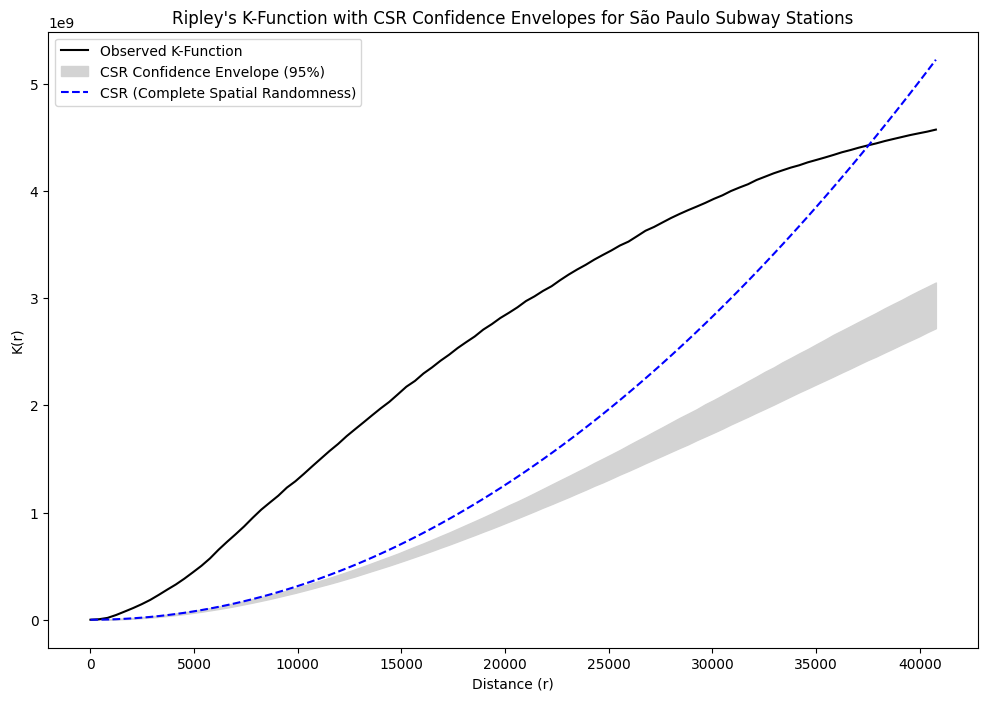

In [6]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix

def ripley_k_function(points, radii, area):
    n = len(points)
    dist_matrix = distance_matrix(points, points)
    k_values = []

    for r in radii:
        count_within_r = np.sum((dist_matrix <= r) & (dist_matrix > 0))
        k_r = (area / (n * (n - 1))) * count_within_r
        k_values.append(k_r)

    return np.array(k_values)

def csr_simulation(area, n_points):
    x_min, y_min, x_max, y_max = area
    x_coords = np.random.uniform(x_min, x_max, n_points)
    y_coords = np.random.uniform(y_min, y_max, n_points)
    return np.vstack((x_coords, y_coords)).T

# Load São Paulo subway stations dataset (assuming combined_gdf is already created)
combined_gdf['x'] = combined_gdf.geometry.x
combined_gdf['y'] = combined_gdf.geometry.y
station_coords = combined_gdf[['x', 'y']].values

# Get bounding box and area size for CSR simulations
xmin, ymin, xmax, ymax = combined_gdf.total_bounds
area = (xmin, ymin, xmax, ymax)
area_size = (xmax - xmin) * (ymax - ymin)

n_stations = len(station_coords)
radii = np.linspace(0, max(xmax - xmin, ymax - ymin) / 2, 100)

# Calculate observed Ripley's K-function
observed_k = ripley_k_function(station_coords, radii, area_size)

# Perform CSR simulations
iterations = 2000
k_simulations = []

for _ in range(iterations):
    csr_points = csr_simulation(area, n_stations)
    k_sim = ripley_k_function(csr_points, radii, area_size)
    k_simulations.append(k_sim)

k_simulations = np.array(k_simulations)
lower_envelope = np.percentile(k_simulations, 2.5, axis=0)
upper_envelope = np.percentile(k_simulations, 97.5, axis=0)

# Calculate CSR theoretical value
k_csr = np.pi * radii**2

# Plot results
plt.figure(figsize=(12, 8), dpi=100)
plt.plot(radii, observed_k, label='Observed K-Function', color='black')
plt.fill_between(radii, lower_envelope, upper_envelope, color='lightgrey', label='CSR Confidence Envelope (95%)')
plt.plot(radii, k_csr, label='CSR (Complete Spatial Randomness)', color='blue', linestyle='--')
plt.xlabel('Distance (r)')
plt.ylabel('K(r)')
plt.title("Ripley's K-Function with CSR Confidence Envelopes for São Paulo Subway Stations")
plt.legend()
plt.show()


# Nova Iorque

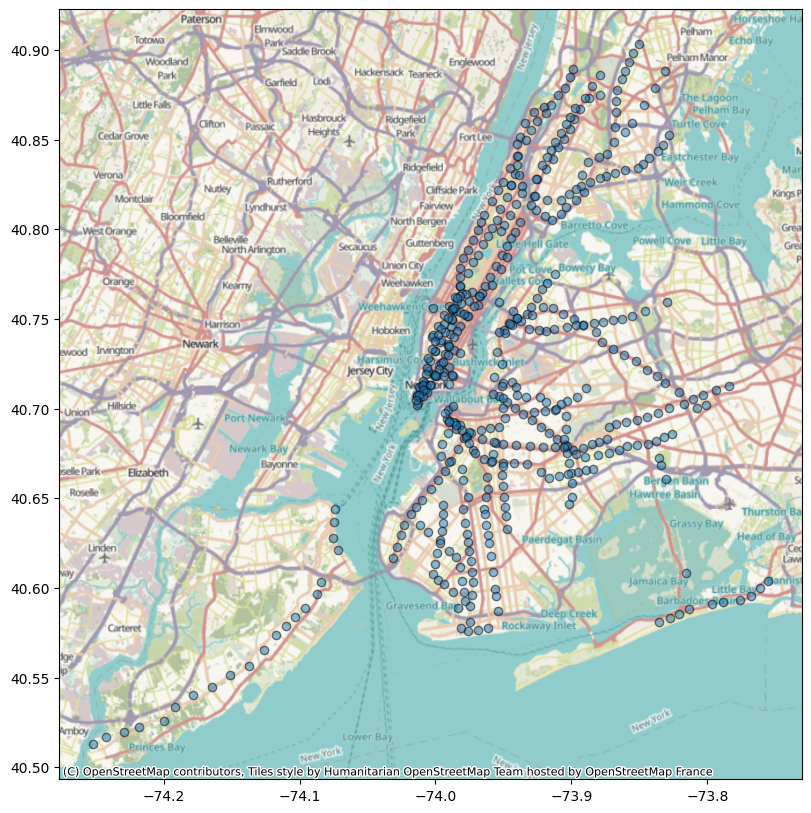

In [3]:
# Path to your GeoJSON file
geojson_file = 'MTA Subway Stations_20241024/geo_export_c1664305-f8f3-482b-9578-db838def4846.shp'

# Read the GeoJSON file into a GeoPandas DataFrame
gdf = gpd.read_file(geojson_file)

# Plot with basemap
ax = gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

# Add a basemap (using a tile service like OpenStreetMap)
ctx.add_basemap(ax, crs=gdf.crs.to_string())

# Show the plot
plt.show()


In [4]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

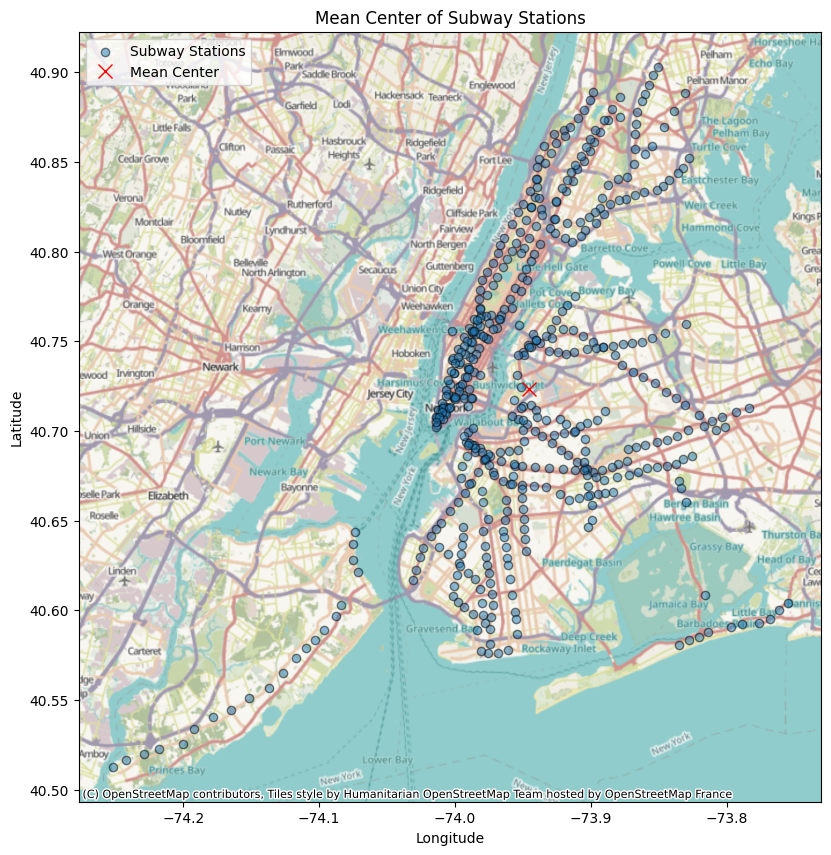

In [7]:
# Path to your GeoJSON file
geojson_file = 'MTA Subway Stations_20241024/geo_export_c1664305-f8f3-482b-9578-db838def4846.shp'

# Read the GeoJSON file into a GeoPandas DataFrame
gdf = gpd.read_file(geojson_file)

# Extract x and y coordinates for mean center calculation
gdf['x'] = gdf.geometry.x
gdf['y'] = gdf.geometry.y

# Create a PointPattern for mean center calculation
coordinates = gdf[['x', 'y']].values
point_pattern = PointPattern(coordinates)

# Calculate mean center
mean_center_coords = mean_center(point_pattern.points)

# Plot with basemap
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, alpha=0.5, edgecolor='k', label="Subway Stations")
ax.plot(mean_center_coords[0], mean_center_coords[1], 'x', markersize=10, color='red', label='Mean Center')

# Add a basemap (using OpenStreetMap tiles)
ctx.add_basemap(ax, crs=gdf.crs.to_string())

# Add title, legend, and labels
plt.legend()
plt.title('Mean Center of Subway Stations')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


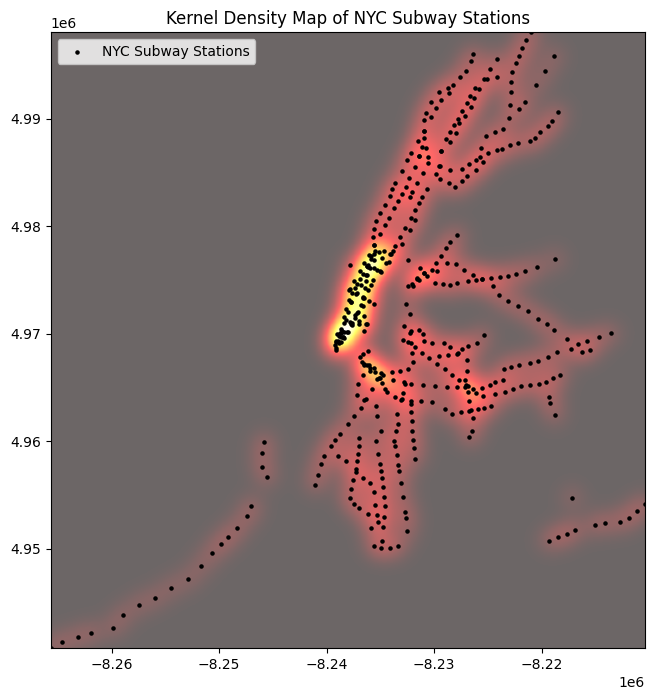

In [9]:
# Path to New York subway stations file
nyc_file = "MTA Subway Stations_20241024/geo_export_c1664305-f8f3-482b-9578-db838def4846.shp"  # Replace with your actual path

# Load the GeoDataFrame for New York subway stations
gdf = gpd.read_file(nyc_file)
gdf = gdf.to_crs(epsg=3857)

# Extract coordinates for KDE
gdf['x'] = gdf.geometry.x
gdf['y'] = gdf.geometry.y
station_coords = gdf[['x', 'y']].values

# Perform KDE
kde = KernelDensity(bandwidth=1000, kernel='gaussian')  # Adjust bandwidth based on scale
kde.fit(station_coords)

# Define the grid
xmin, ymin, xmax, ymax = gdf.total_bounds
xgrid = np.linspace(xmin, xmax, 500)
ygrid = np.linspace(ymin, ymax, 500)
xv, yv = np.meshgrid(xgrid, ygrid)
grid_coords = np.vstack([xv.ravel(), yv.ravel()]).T

# Calculate density
density = np.exp(kde.score_samples(grid_coords))
density = density.reshape(500, 500)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot subway station points
gdf.plot(ax=ax, color='black', markersize=5, label='NYC Subway Stations')

# Add KDE density map
ax.imshow(density, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='hot', alpha=0.6)

# Title and legend
ax.set_title('Kernel Density Map of NYC Subway Stations')
ax.legend()

plt.show()


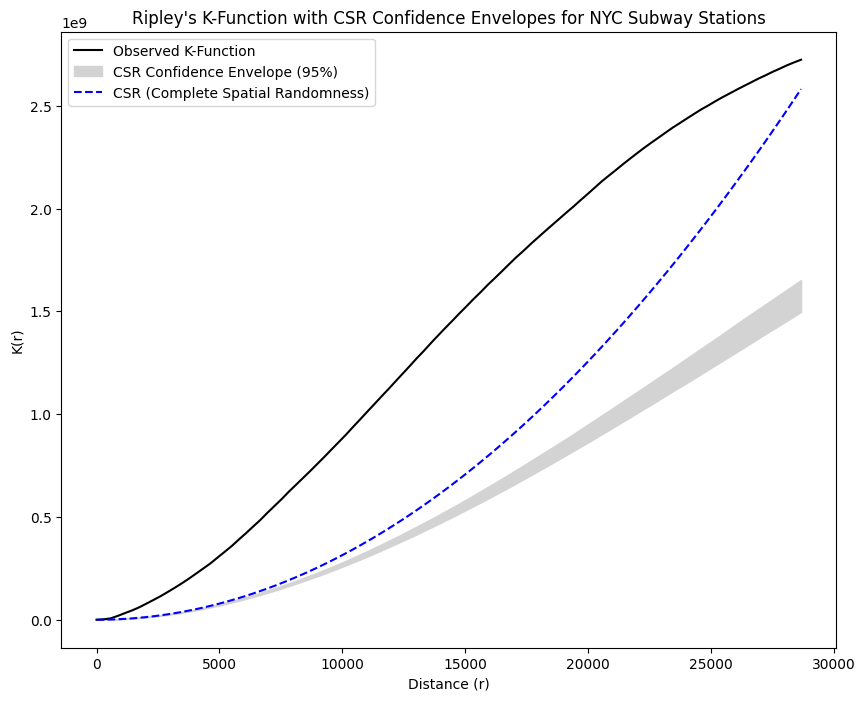

In [15]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from pointpats import PointPattern
from pointpats.distance_statistics import k

def ripley_k_function(points, radii, area):
    n = len(points)
    dist_matrix = distance_matrix(points, points)
    k_values = []

    for r in radii:
        count_within_r = np.sum((dist_matrix <= r) & (dist_matrix > 0))
        k_r = (area / (n * (n - 1))) * count_within_r
        k_values.append(k_r)

    return np.array(k_values)

def csr_simulation(area, n_points):
    x_min, y_min, x_max, y_max = area
    x_coords = np.random.uniform(x_min, x_max, n_points)
    y_coords = np.random.uniform(y_min, y_max, n_points)
    return np.vstack((x_coords, y_coords)).T

# Load New York subway stations dataset
nyc_file = "MTA Subway Stations_20241024/geo_export_c1664305-f8f3-482b-9578-db838def4846.shp"
gdf = gpd.read_file(nyc_file)

# Ensure the CRS is set; if not, set it to WGS84 (EPSG:4326)
if gdf.crs is None:
    gdf = gdf.set_crs("EPSG:4326")

# Reproject to planar coordinates (Web Mercator EPSG:3857)
gdf = gdf.to_crs("EPSG:3857")

# Filter for Point geometries only
gdf = gdf[gdf.geometry.type == "Point"]

# Extract coordinates
station_coords = np.array([(point.x, point.y) for point in gdf.geometry])

# Get bounding box and area size for CSR simulations
xmin, ymin, xmax, ymax = gdf.total_bounds
area = (xmin, ymin, xmax, ymax)
area_size = (xmax - xmin) * (ymax - ymin)

n_stations = len(station_coords)
radii = np.linspace(0, max(xmax - xmin, ymax - ymin) / 2, 100)

# Calculate observed Ripley's K-function
observed_k = ripley_k_function(station_coords, radii, area_size)

# Perform CSR simulations
iterations = 2000
k_simulations = []

for _ in range(iterations):
    csr_points = csr_simulation(area, n_stations)
    k_sim = ripley_k_function(csr_points, radii, area_size)
    k_simulations.append(k_sim)

k_simulations = np.array(k_simulations)
lower_envelope = np.percentile(k_simulations, 2.5, axis=0)
upper_envelope = np.percentile(k_simulations, 97.5, axis=0)

# Calculate CSR theoretical value
k_csr = np.pi * radii**2

# Plot results
plt.figure(figsize=(10, 8))
plt.plot(radii, observed_k, label='Observed K-Function', color='black')
plt.fill_between(radii, lower_envelope, upper_envelope, color='lightgrey', label='CSR Confidence Envelope (95%)')
plt.plot(radii, k_csr, label='CSR (Complete Spatial Randomness)', color='blue', linestyle='--')
plt.xlabel('Distance (r)')
plt.ylabel('K(r)')
plt.title("Ripley's K-Function with CSR Confidence Envelopes for NYC Subway Stations")
plt.legend()
plt.show()


Interpretation:

Clustering Indication: The black line (observed K-function) lies well above the gray CSR envelope across all distances. This suggests that NYC subway stations are highly clustered.

Scale of Clustering: The observed K-function remains above the envelope even at large distances, indicating that clustering is evident at both local (short distances) and broader spatial scales (larger distances).

Spatial Meaning: This clustering behavior is typical for urban transit infrastructure, as subway stations tend to cluster around key areas like city centers, major transport hubs, and densely populated regions to maximize accessibility.

Conclusion:

The plot indicates a strong clustering tendency for NYC subway stations. The clustering is significant compared to what would be expected if the stations were randomly distributed across the area, reflecting intentional design patterns in urban transportation planning to serve high-demand areas efficiently.








# Londres

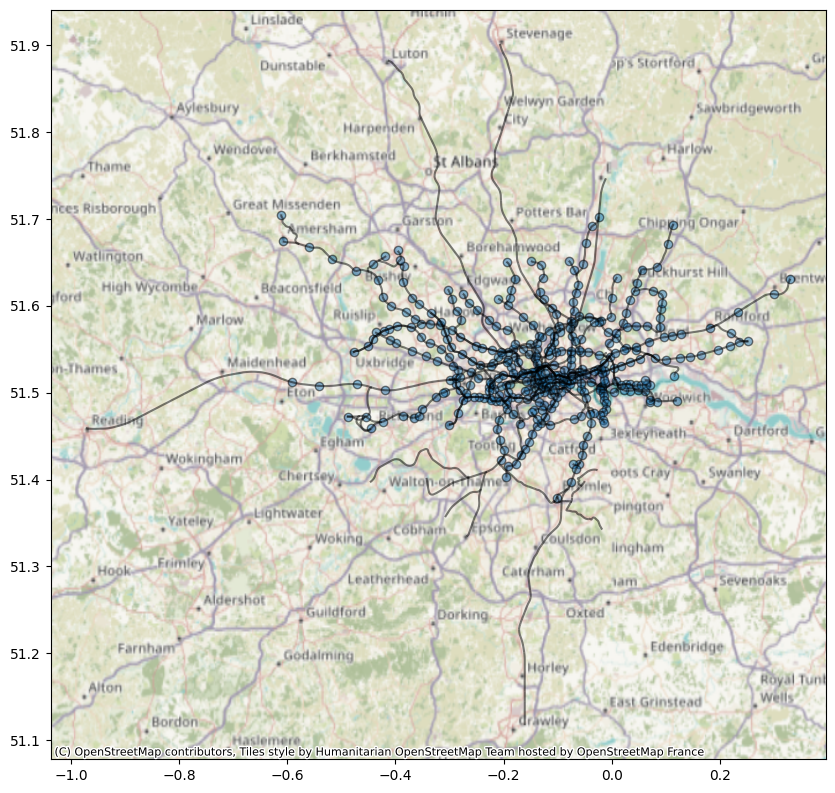

     id end_sid  name start_sid                   geometry
0  None    None  None      None   POINT (-0.1201 51.51711)
1  None    None  None      None  POINT (-0.11178 51.51818)
2  None    None  None      None   POINT (-0.1243 51.51309)
3  None    None  None      None  POINT (-0.12826 51.51148)
4  None    None  None      None  POINT (-0.11436 51.51097)


In [5]:
# Path to your GeoJSON file
geojson_file = 'data\ldn\london_stations.geojson'

# Read the GeoJSON file into a GeoPandas DataFrame
gdf = gpd.read_file(geojson_file)
ax = gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, crs=gdf.crs.to_string())
# Show the plot
plt.show()


# Display the first few rows of the GeoDataFrame
print(gdf.head())


In [6]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

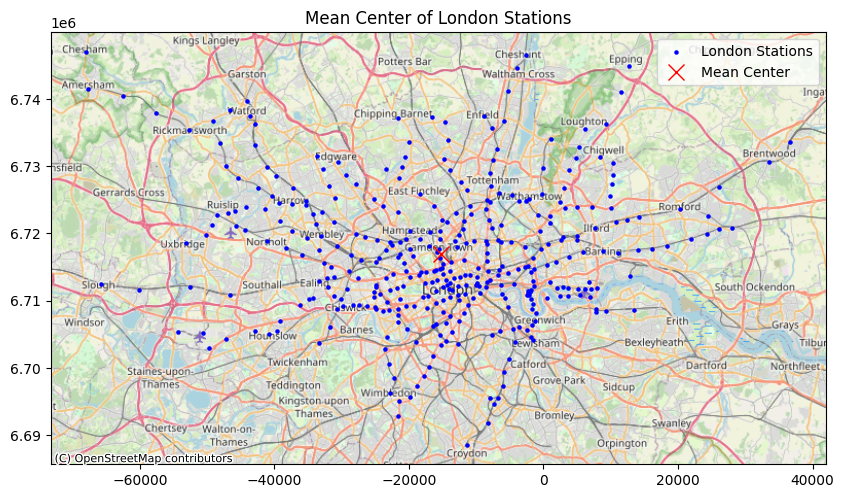

In [10]:
# Load the GeoDataFrame
geojson_file = 'data/ldn/london_stations.geojson'
gdf = gpd.read_file(geojson_file)

# Ensure CRS is set and reproject to Web Mercator for compatibility with basemaps
if gdf.crs is None:
    gdf = gdf.set_crs("EPSG:4326")
gdf = gdf.to_crs("EPSG:3857")

# Filter for Point geometries only
gdf = gdf[gdf.geometry.type == "Point"]

# Extract x and y coordinates for mean center calculation
gdf['x'] = gdf.geometry.x
gdf['y'] = gdf.geometry.y
station_coords = gdf[['x', 'y']].values

# Calculate mean center using pointpats
point_pattern = PointPattern(station_coords)
mean_center_coords = mean_center(point_pattern.points)

# Plot stations, mean center, and basemap
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color='blue', markersize=5, label='London Stations')
ax.plot(mean_center_coords[0], mean_center_coords[1], 'x', color='red', markersize=12, label='Mean Center')

# Add basemap
ctx.add_basemap(ax, crs=gdf.crs, source=ctx.providers.OpenStreetMap.Mapnik)

# Add title and legend
plt.title("Mean Center of London Stations")
plt.legend()
plt.show()


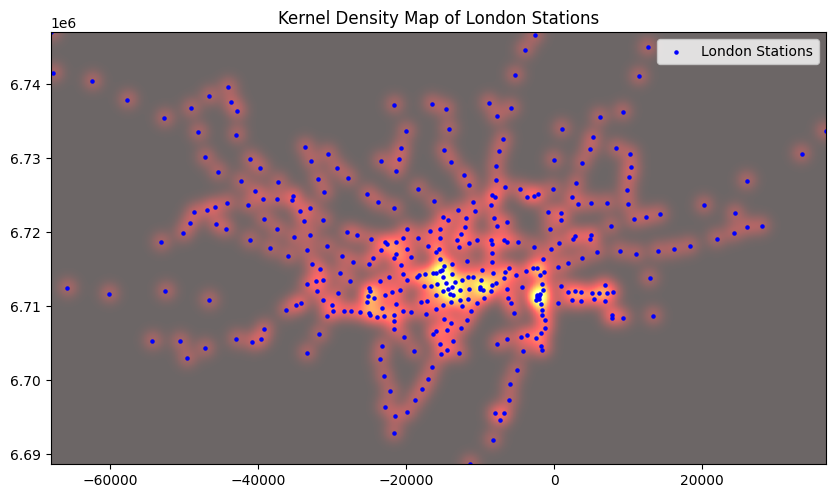

In [11]:
# Path to your GeoJSON file
geojson_file = 'data/ldn/london_stations.geojson'

# Load the GeoDataFrame
gdf = gpd.read_file(geojson_file)

# Ensure CRS is set and reproject to Web Mercator for compatibility with basemaps
if gdf.crs is None:
    gdf = gdf.set_crs("EPSG:4326")
gdf = gdf.to_crs("EPSG:3857")

# Filter for Point geometries only
gdf = gdf[gdf.geometry.type == "Point"]

# Extract x and y coordinates for KDE
gdf['x'] = gdf.geometry.x
gdf['y'] = gdf.geometry.y
station_coords = gdf[['x', 'y']].values

# Perform KDE
kde = KernelDensity(bandwidth=1000, kernel='gaussian')  # Adjust bandwidth as needed
kde.fit(station_coords)

# Define grid for density calculation
xmin, ymin, xmax, ymax = gdf.total_bounds
xgrid = np.linspace(xmin, xmax, 500)
ygrid = np.linspace(ymin, ymax, 500)
xv, yv = np.meshgrid(xgrid, ygrid)
grid_coords = np.vstack([xv.ravel(), yv.ravel()]).T

# Calculate density
density = np.exp(kde.score_samples(grid_coords))
density = density.reshape(500, 500)

# Plot KDE with station points
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(density, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='hot', alpha=0.6)
gdf.plot(ax=ax, color='blue', markersize=5, label='London Stations')

# Add basemap for context
#ctx.add_basemap(ax, crs=gdf.crs, source=ctx.providers.OpenStreetMap.Mapnik)

# Add title and legend
plt.title("Kernel Density Map of London Stations")
plt.legend()
plt.show()


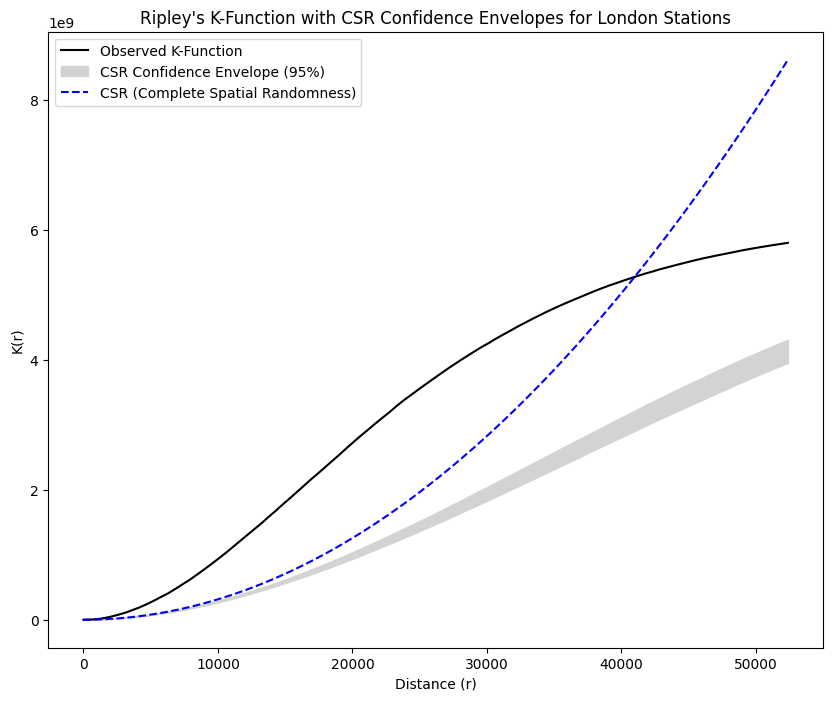

In [13]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from pointpats import PointPattern
from pointpats.distance_statistics import k

def ripley_k_function(points, radii, area):
    n = len(points)
    dist_matrix = distance_matrix(points, points)
    k_values = []

    for r in radii:
        count_within_r = np.sum((dist_matrix <= r) & (dist_matrix > 0))
        k_r = (area / (n * (n - 1))) * count_within_r
        k_values.append(k_r)

    return np.array(k_values)

def csr_simulation(area, n_points):
    x_min, y_min, x_max, y_max = area
    x_coords = np.random.uniform(x_min, x_max, n_points)
    y_coords = np.random.uniform(y_min, y_max, n_points)
    return np.vstack((x_coords, y_coords)).T

# Load London stations dataset
geojson_file = 'data/ldn/london_stations.geojson'
gdf = gpd.read_file(geojson_file)

# Filter for points only if needed and reproject to planar coordinates
if gdf.crs is None:
    gdf = gdf.set_crs("EPSG:4326")
gdf = gdf.to_crs("EPSG:3857")

# Filter to include only Point geometries
gdf = gdf[gdf.geometry.type == "Point"]

# Extract coordinates
station_coords = np.array([(point.x, point.y) for point in gdf.geometry])

# Get bounding box and area size for CSR simulations
xmin, ymin, xmax, ymax = gdf.total_bounds
area = (xmin, ymin, xmax, ymax)
area_size = (xmax - xmin) * (ymax - ymin)

n_stations = len(station_coords)
radii = np.linspace(0, max(xmax - xmin, ymax - ymin) / 2, 100)

# Calculate observed Ripley's K-function
observed_k = ripley_k_function(station_coords, radii, area_size)

# Perform CSR simulations
iterations = 2000
k_simulations = []

for _ in range(iterations):
    csr_points = csr_simulation(area, n_stations)
    k_sim = ripley_k_function(csr_points, radii, area_size)
    k_simulations.append(k_sim)

k_simulations = np.array(k_simulations)
lower_envelope = np.percentile(k_simulations, 2.5, axis=0)
upper_envelope = np.percentile(k_simulations, 97.5, axis=0)

# Calculate CSR theoretical value
k_csr = np.pi * radii**2

# Plot results
plt.figure(figsize=(10, 8))
plt.plot(radii, observed_k, label='Observed K-Function', color='black')
plt.fill_between(radii, lower_envelope, upper_envelope, color='lightgrey', label='CSR Confidence Envelope (95%)')
plt.plot(radii, k_csr, label='CSR (Complete Spatial Randomness)', color='blue', linestyle='--')
plt.xlabel('Distance (r)')
plt.ylabel('K(r)')
plt.title("Ripley's K-Function with CSR Confidence Envelopes for London Stations")
plt.legend()
plt.show()


Interpretation:

When the observed K-function (black line) lies above the CSR envelope, it suggests that the London stations are more clustered than would be expected under complete spatial randomness.

If the black line were below the CSR envelope, it would suggest a more dispersed distribution.
The fact that the black line stays above the CSR confidence envelope throughout the plot indicates significant clustering of London stations over the range of distances examined.

Conclusion:

The plot suggests that the London stations are spatially clustered compared to what would be expected from a random distribution of points in the same area. This is a common finding for urban infrastructure, as stations tend to cluster around key transit hubs and densely populated or high-demand areas.

More clustered than NYC, may be due to geography of both cities







## Análise

Observed K-Function vs. CSR Envelope
   
São Paulo: The observed K-function for São Paulo lies significantly above the CSR envelope throughout the range of distances. This indicates a strong clustering tendency of subway stations, with clustering being pronounced at smaller distances and continuing at larger scales.

NYC: The observed K-function for NYC is also consistently above the CSR envelope, indicating clustering. However, the magnitude of clustering (i.e., the extent to which the K-function exceeds the CSR line) is lower compared to São Paulo and London at longer distances.

London: London shows the highest K-function values among the three cities, suggesting the strongest clustering effect. The separation of the observed K-function from the CSR envelope is substantial, indicating a dense clustering of stations across various distances.

NYC has the best clustering in short distances due to geography of the city, specifically Manhattan, being lodged between two rivers. As such, high clustering in the highest density area, and expanding to other boroughs, clustering gets weaker as population density does as well. London and São Paulo have the most similar layout geographically, and London shows the best K-function value, indicating that São Paulo lacks subway apparatus for dealing with it's population.

## Conclusão

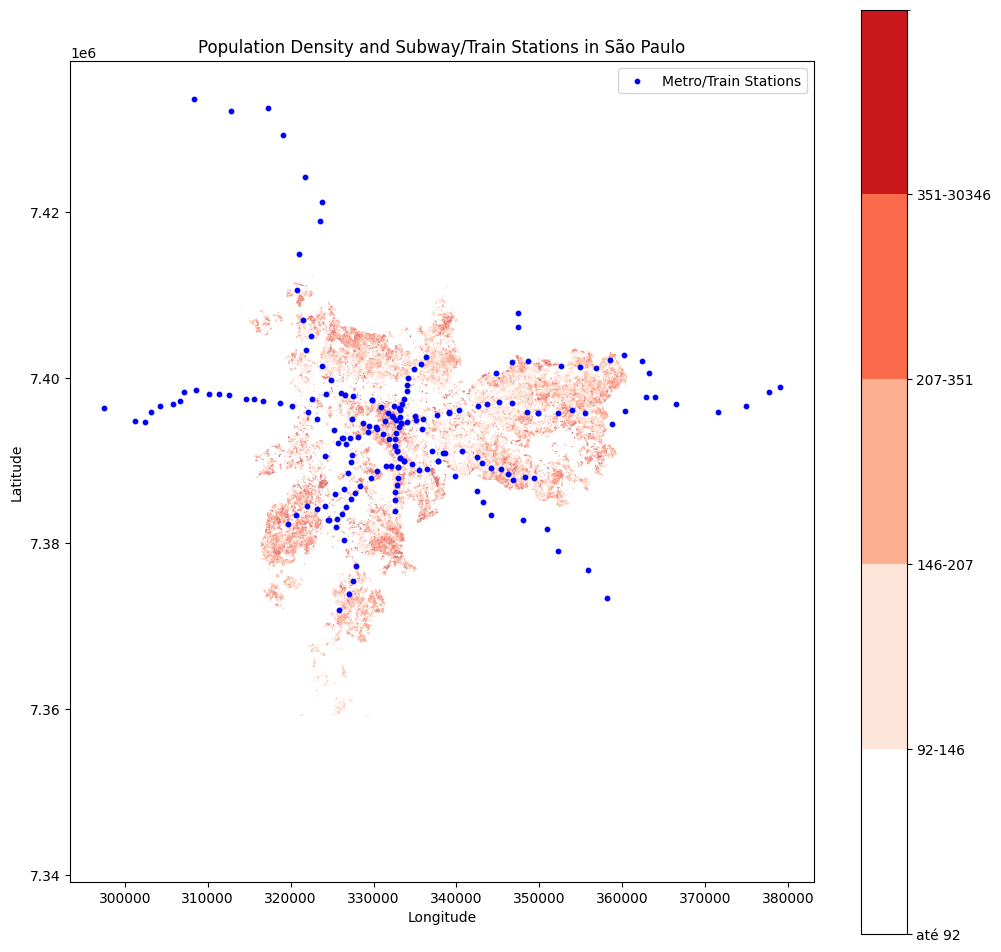

In [44]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.colors as mcolors

# Load the station data (metro and train points)
directory = "data/metro_trem_sp/"
shapefiles = ["SIRGAS_SHP_estacaometro_point.shp", "SIRGAS_SHP_estacaotrem.shp"]
gdfs = [gpd.read_file(directory + shp) for shp in shapefiles]
combined_stations_gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))

# Load the population density data
file_path = 'data/metro_trem_sp/SIRGAS_SHP_densidadedemografica.shp'
density_gdf = gpd.read_file(file_path)

# Define custom bins and colors based on your legend ranges for density
bins = [0, 92, 146, 207, 351, 30346]
colors = ['#ffffff', '#fee5d9', '#fcae91', '#fb6a4a', '#cb181d']
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(bins, len(colors))

# Plot the density data with custom classification
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
density_gdf.plot(column='dd_hab_hec', cmap=cmap, norm=norm, linewidth=0.8, ax=ax, alpha=0.7,)

# Overlay the station data
combined_stations_gdf.plot(ax=ax, color='blue', markersize=10, label='Metro/Train Stations')

# Add a colorbar with custom ticks and labels
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_ticks(bins[:-1])
cbar.set_ticklabels(['até 92', '92-146', '146-207', '207-351', '351-30346'])

# Add title, labels, and legend
plt.title('Population Density and Subway/Train Stations in São Paulo')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

plt.show()


By plotting the map of existing subway stops on top of the map indicating population density in São Paulo, certain projections can be made as to where future stops should be built. The districts of:

1. Casa Verde-Cachoeirinha ZN
2. Freguesia-Brasilândia ZN
3. Jaçanã-Tremembé ZN
4. Campo Limpo ZS
5. M'Boi Mirim ZS
6. Butantã ZO
7. Cidade Ademar ZS
8. São Mateus ZL
9. Itaquera ZL
10. Cidade Tiradentes ZL
11. Itaim Paulista ZL
12. São Miguel ZL
13. Ermelino Matarazzo ZL

Have been identified as being in most need of further support in São Paulo's urban Railway Network.

### Referências Bibliográficas

https://github.com/lenkahas/London_tube_spatial_files

https://github.com/oobrien/vis/tree/master/tubecreature/data

https://data.europa.eu/data/datasets?locale=en

https://data.ny.gov/Transportation/MTA-Subway-Stations/39hk-dx4f/about_data